In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')
import re
import shutil
import string

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

2022-06-09 13:27:00.881353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 13:27:00.881431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Import train dataset with Pandas 

trainset = pd.read_csv("train.csv")
trainset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Some stats on train dataset

trainset.shape
print(trainset.shape)
print()
trainset.target.value_counts()
print(trainset.target.value_counts())
print()

(7613, 5)

0    4342
1    3271
Name: target, dtype: int64



In [5]:
# Let's take the columns we're interested in 

clean_trainset = trainset[["id","text", "target"]]
clean_trainset.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# installation of spacy library

!pip install spacy -q
!python -m spacy download en_core_web_sm -q

2022-06-09 13:27:10.191994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 13:27:10.192053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
# loading of the model

import en_core_web_sm
nlp = en_core_web_sm.load()

In [8]:
# Import Stop words 

from spacy.lang.en.stop_words import STOP_WORDS

In [9]:
print(STOP_WORDS)

{'she', '‘ll', 'yourself', 'becoming', 'former', 'throughout', 'some', 'will', 'everything', 'ten', 'unless', "'re", 'hereafter', 'their', "'s", 'n‘t', 'always', 'four', 'made', 'one', 'ours', 'now', 'nowhere', 'hundred', 'into', 'once', 'over', 'therein', 'go', 'himself', 'hers', 'i', '’ve', 'cannot', 'wherein', 'ca', 'herself', 'six', 'much', 'these', 'have', 'being', 'off', 'either', 'anything', 'never', 'onto', 'again', 'sometimes', 'indeed', 'might', 'give', 'whole', 'amount', "'ll", 'our', 'though', 'why', 'against', 'within', 'her', 'hereby', 'becomes', 'each', 'see', 'yet', 'hereupon', 'whereby', 'noone', 'become', 'most', 'first', 'least', 'about', 'all', 'were', 'third', 'alone', 'as', '‘s', 'that', 'formerly', 'keep', 'move', '’s', "n't", '’re', 'whom', "'m", 'bottom', 'upon', 'really', '‘ve', 'mine', 'on', 'this', 'here', 'say', 'he', 'ever', 'per', 'it', 'besides', 'latter', 'whereas', 'twenty', 'who', 'since', 'further', 'so', 'others', 'of', '’d', 'behind', 'sixty', 'who

In [27]:
#Check lemmatization principe

a = nlp("car cars care caring")

In [11]:
[element.lemma_ for element in a]

['car', 'car', 'care', 'care']

In [12]:
#cleaning of the text

# Remove all non alphanumeric characters except whitespaces
clean_trainset["text_clean"] = clean_trainset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# remove double spaces and spaces at the beginning and end of strings
clean_trainset["text_clean"] = clean_trainset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# remove stop words and replace everyword with their lemma
clean_trainset["text_clean"] = clean_trainset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [13]:
# Concatenation

clean_trainset = clean_trainset[["text","text_clean","target"]]
clean_trainset.head()

,text,text_clean,target
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,1
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...,1
4,Just got sent this photo from Ruby #Alaska as ...,got send photo ruby alaska smoke wildfire pour...,1


In [14]:
# Tokenizer process to encoding all the reviews for dataset

import numpy as np

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
# num_words indicates the number of words to keep in the tokenization
# keeps only the most common words

tokenizer.fit_on_texts(clean_trainset.text_clean) # fit the tokenizer on the texts
# in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.

clean_trainset["review_encoded"] = tokenizer.texts_to_sequences(clean_trainset.text_clean) # transform texts into sequences of indices


# Sometimes the preprocessing removes all the words in a string (because they contain
# only stopwords for example) so we calculate the length in order to filter out
# those records
clean_trainset["len_review"] = clean_trainset["review_encoded"].apply(lambda x: len(x)) # calulate length records

clean_trainset = clean_trainset[clean_trainset["len_review"]!=0] # To delete len_review = 0


In [15]:
clean_trainset.head()

,text,text_clean,target,review_encoded,len_review
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1,"[3669, 414, 172, 1381, 1942]",5
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1,"[117, 3, 159, 512, 5555, 5556, 1016]",7
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,1,"[1382, 447, 1698, 323, 5557, 293, 189, 1698, 3...",11
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...,1,"[2304, 7, 2305, 70, 189, 279, 35]",7
4,Just got sent this photo from Ruby #Alaska as ...,got send photo ruby alaska smoke wildfire pour...,1,"[280, 177, 123, 5558, 1699, 168, 70, 2306, 111]",9


In [16]:
# We are almost done now, the texts have been converted into sequences of integers. 
# However to form a tensorflow dataset, all the sequences must be of the same length, 
# so we'll use padding. Padding will result in adding zeros at the end or the beginning of each sentence in order 
# for all sequences to get the same length.

train_pad = tf.keras.preprocessing.sequence.pad_sequences(clean_trainset.review_encoded, padding="post")
train_pad[0:5]

array([[3669,  414,  172, 1381, 1942,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 117,    3,  159,  512, 5555, 5556, 1016,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [1382,  447, 1698,  323, 5557,  293,  189, 1698,  323,  279,  380,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [2304,    7, 2305,   70,  189,  279,   35,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 280,  177,  123, 5558, 1699,  168,   70, 2306,  111,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [17]:
# Size of vocabulary

vocab_size = len(tokenizer.index_word)
print(tokenizer.index_word)
print('Size of vocabulary:', vocab_size)

# We have 20236 unique word

{1: 'like', 2: 'm', 3: 'fire', 4: 'amp', 5: 's', 6: 'new', 7: 'people', 8: 'news', 9: 'video', 10: 'kill', 11: 'burn', 12: '2', 13: 'crash', 14: 'come', 15: 'emergency', 16: 'bomb', 17: 'disaster', 18: 'attack', 19: 'body', 20: 'year', 21: 'time', 22: 'look', 23: 'police', 24: 'man', 25: 'home', 26: 'flood', 27: 'day', 28: 'know', 29: 'family', 30: 'think', 31: 'good', 32: 'building', 33: 'love', 34: 'storm', 35: 'california', 36: 'train', 37: 'watch', 38: 'suicide', 39: 'want', 40: 'world', 41: 'collapse', 42: 'life', 43: 'car', 44: 'scream', 45: 'death', 46: 'bag', 47: '3', 48: 'rt', 49: 'cause', 50: 'work', 51: 'need', 52: 'nuclear', 53: 'drown', 54: 'today', 55: 'youtube', 56: 'wreck', 57: 'war', 58: 'accident', 59: 'destroy', 60: 'dead', 61: 'let', 62: 'plan', 63: 'fear', 64: 'help', 65: 'weapon', 66: 'feel', 67: 'hiroshima', 68: 'live', 69: 'way', 70: 'wildfire', 71: 'find', 72: 'u', 73: 'blow', 74: 'pm', 75: 'injury', 76: 'survive', 77: 'bad', 78: 'big', 79: 'rescue', 80: 'evacu

In [18]:
# We'll use this to form a tensorflow dataset containing on the one hand
# the encoded texts and the target.

train_ds = tf.data.Dataset.from_tensor_slices((train_pad, clean_trainset.target))

2022-06-09 13:28:36.400669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 13:28:36.400738: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 13:28:36.400780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-gregcolongo-40yahoo-2efr): /proc/driver/nvidia/version does not exist
2022-06-09 13:28:36.401295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#Train/test split

TAKE_SIZE = int(0.7*clean_trainset.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

test_data = train_ds.skip(TAKE_SIZE)
test_data = test_data.batch(32)

In [20]:
#Model

vocab_size = tokenizer.num_words

embedding_dim=16 

model = tf.keras.Sequential([
                            
                  tf.keras.layers.Embedding(vocab_size+1,embedding_dim,name="embedding"),
 
                  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence
  # along each dimension of the representation space.
                  
                    Dense(16, activation='relu'), # First layer
                    Dense(8, activation='relu'),# dense layer
                    Dense(1, activation="sigmoid") # the prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
__________________________________________________

In [21]:
#compilation of model

optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=20,
                    validation_data=test_data)



Epoch 1/20
167/167 [==============================] - 2s 7ms/step - loss: 0.6767 - accuracy: 0.5751 - val_loss: 0.6706 - val_accuracy: 0.5581
Epoch 2/20
167/167 [==============================] - 1s 6ms/step - loss: 0.5783 - accuracy: 0.7109 - val_loss: 0.5370 - val_accuracy: 0.7402
Epoch 3/20
167/167 [==============================] - 1s 6ms/step - loss: 0.3720 - accuracy: 0.8525 - val_loss: 0.4914 - val_accuracy: 0.7701
Epoch 4/20
167/167 [==============================] - 1s 6ms/step - loss: 0.2814 - accuracy: 0.8905 - val_loss: 0.5094 - val_accuracy: 0.7530
Epoch 5/20
167/167 [==============================] - 1s 6ms/step - loss: 0.2287 - accuracy: 0.9137 - val_loss: 0.5177 - val_accuracy: 0.7648
Epoch 6/20
167/167 [==============================] - 1s 6ms/step - loss: 0.1862 - accuracy: 0.9302 - val_loss: 0.5644 - val_accuracy: 0.7688
Epoch 7/20
167/167 [==============================] - 1s 6ms/step - loss: 0.1549 - accuracy: 0.9421 - val_loss: 0.6113 - val_accuracy: 0.7345
Epoch 

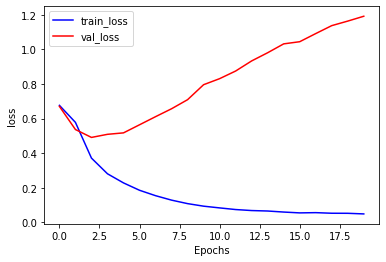

In [23]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b",label='train_loss')
plt.plot(history.history["val_loss"], color="r",label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper left")
plt.show()


In [24]:
# 

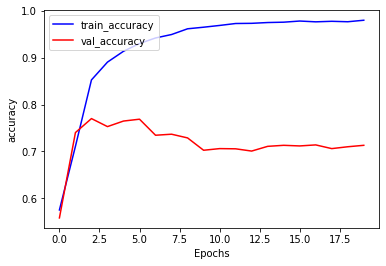

In [25]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b",label='train_accuracy')
plt.plot(history.history["val_accuracy"], color="r",label='val_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="upper left")
plt.show()

In [26]:
# Conclusions

# Model is too specialized on trainset...we are in overfitting situation because
# train_loss decreases and val_loss increases for these datas.

# We can confirm our assumptions on accuracy graph showing that from the 2nd epoch, 
# accuracy decreases for validation dataset and increases for train dataset 

# This model is not able to perform on validation datas and globally on real datas

# Solutions to improve model --> Reduce the number of epochs (but already down !)
#                            --> To increase number of neuron layers
#                            --> Loss fuction ?
#                            --> Batch sizes and hyperparameters
#                            --> Switch to Simple RNN or complex layers as GRU or LSTM

